# Microwave Radiometer Temperature and Humidity Retrieval

to do: introduce retrieval

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
import xarray as xr
import seaborn as sns
import sys

import pyOptimalEstimation as pyOE
import pamtra2

sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

In [2]:
%%time
nonScatMWRadTran.doTests()

CPU times: user 74.7 ms, sys: 11.9 ms, total: 86.5 ms
Wall time: 85.6 ms


# Load data
radiosonde at Barrow at 2004-03-16T12:00:00

In [3]:
allData = xr.open_dataset('data/radiosonde_prior.nc')

profileII =0
x_truth = allData['x_truth'].isel(time=0)
x_mean = allData['x_mean']
x_cov = allData['x_cov']
pressure = allData['pressure']
height = allData['height']




# forward operator

In [4]:
def q2a(q, p, T):
    Rair = 287.04  # J/kg/K
    Rvapor = 461.5  # J/kg/K
    rho = p / (Rair * T * (1 + (Rvapor / Rair - 1) * q)) #density kg/m3
    return q*rho


def forwardRT(X,  pressure=None, zenithAngle=0, frequencies=[]):
    
    temperature, humidity = supporting_routines.splitTQ(X)
    heights = temperature.index
    
    assert np.all(np.diff(heights)>0)
    
    abs_humidity = q2a(humidity/1000., pressure, temperature)
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m] states grid of T_final [K], p_final [Pa], q_final [kgm^-3]
        temperature ,
        pressure ,
        abs_humidity,
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

frequencies = [22.24 , 23.04, 23.84, 25.44, 26.24, 27.84, 31.4 , 51.26, 52.28, 53.86,
       54.94, 56.66, 57.3 , 58. ]





# Run retrieval

In [5]:
y_vars = frequencies
x_vars = x_mean.state.values
x_ap = x_mean.sel(season='DJF').to_pandas()
x_cov1 = x_cov.sel(season='DJF').to_pandas()
y_obs = forwardRT(x_truth.to_pandas(), pressure=pressure.sel(season='DJF').values, frequencies=frequencies)
y_obs = pn.Series(y_obs,index=y_vars)
assert np.all(np.isfinite(y_obs))
y_noise = pn.Series([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.7, 0.5, 0.5, 0.3, 0.3, 0.3],index=y_vars)
y_cov = pn.DataFrame(
            np.diag(y_noise.values**2),
            index=y_vars,
            columns=y_vars,
        )
pressure = pressure.sel(season='DJF')
forwardKwArgs = dict(
    pressure=pressure,
    zenithAngle=0,
    frequencies=frequencies)

b_vars = []
b_param = []
b_cov = [[]]
y_obs

22.24     11.288019
23.04     11.160999
23.84     10.687005
25.44      9.998009
26.24      9.907940
27.84     10.080765
31.40     11.467410
51.26    104.090376
52.28    142.101807
53.86    229.097026
54.94    252.842586
56.66    253.321542
57.30    252.661818
58.00    252.106817
dtype: float64

## reference

The reference run using a prior based on December, January and February radiosondes. 

3.57 s, iteration 1, degrees of freedom: 3.96 of 120. convergence criteria fullfilled  0.006
5.35 s, iteration 2, degrees of freedom: 3.96 of 120.  Done.  0.000
[2.62600840948649, 0.07667243627052521]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


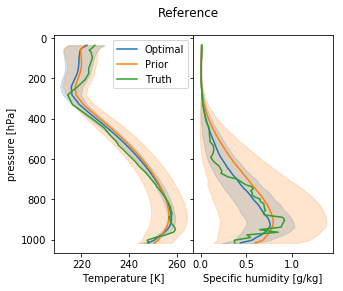

In [6]:
oe_ref = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='DJF').to_pandas(),
    x_cov.sel(season='DJF').to_pandas(),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth.to_pandas(),
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)

oe_ref.doRetrieval()

supporting_routines.plotMwrResults(oe_ref, h=pressure/100, hlabel ='pressure [hPa]', title='Reference')


print([np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_ref.x_op), supporting_routines.splitTQ(oe_ref.x_truth))])
print(oe_ref.chiSquareTest()[0])


## all seasons for prior
Use prior based on all seasons

4.20 s, iteration 1, degrees of freedom: 4.22 of 120. convergence criteria NOT fullfilled  1.973
6.27 s, iteration 2, degrees of freedom: 4.22 of 120. convergence criteria fullfilled  0.000
8.09 s, iteration 3, degrees of freedom: 4.22 of 120.  Done.  0.000
RMS [2.3438518922444715, 0.07316547103964353]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool


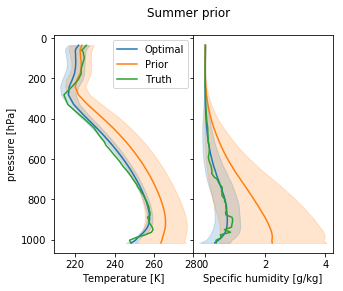

In [7]:
oe_all = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='all').to_pandas(),
    x_cov.sel(season='all').to_pandas(),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_all.doRetrieval()

supporting_routines.plotMwrResults(oe_all, h=pressure/100, hlabel ='pressure [hPa]', title='Summer prior')
print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_all.x_op), supporting_routines.splitTQ(oe_all.x_truth))])
print(oe_all.chiSquareTest()[0])



## summer

Use summer prior instead of winter

3.46 s, iteration 1, degrees of freedom: 4.06 of 120. convergence criteria NOT fullfilled  6.818
5.31 s, iteration 2, degrees of freedom: 3.95 of 120. convergence criteria NOT fullfilled  2.601
7.37 s, iteration 3, degrees of freedom: 3.92 of 120. convergence criteria fullfilled  0.009
9.45 s, iteration 4, degrees of freedom: 3.92 of 120.  Done.  0.000
RMS [5.278891218252541, 0.40851920753906373]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


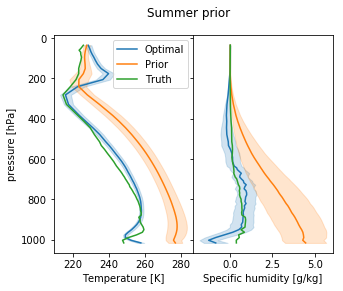

In [8]:
oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='JJA').to_pandas(),
    x_cov.sel(season='JJA').to_pandas(),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_sum.doRetrieval()

supporting_routines.plotMwrResults(oe_sum, h=pressure/100, hlabel ='pressure [hPa]', title='Summer prior')

print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_sum.x_op), supporting_routines.splitTQ(oe_sum.x_truth))])
print(oe_sum.chiSquareTest()[0])






## diagonal prior

3.70 s, iteration 1, degrees of freedom: 3.29 of 120. convergence criteria fullfilled  0.014
5.70 s, iteration 2, degrees of freedom: 3.29 of 120.  Done.  0.000
RMS [2.6173036668862935, 0.10416628977170002]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


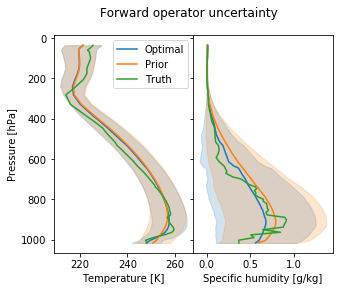

In [9]:
oe_diag = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='DJF').to_pandas(),
    np.diag(np.diag(x_cov.sel(season='DJF'))),
    y_vars,
    y_obs,
    y_cov,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_diag.doRetrieval()



supporting_routines.plotMwrResults(oe_diag, h=pressure/100, hlabel ='Pressure [hPa]', title='Forward operator uncertainty')


print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_diag.x_op), supporting_routines.splitTQ(oe_diag.x_truth))])
print(oe_diag.chiSquareTest()[0])


## Forward operator uncertainty

Add errors of D. Cimini's study:

In [10]:
Syb = pn.DataFrame(np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 3.0, 3.3, 1.2, 0.3, 0.0, 0.0, 0.0],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.7, 8.7, 9.2, 0.3, 0.3, 0.0, 0.0, 0.0],
    [0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.7, 8.2, 8.7, 0.3, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
]),
                  index=frequencies[::-1],
                  columns=frequencies)

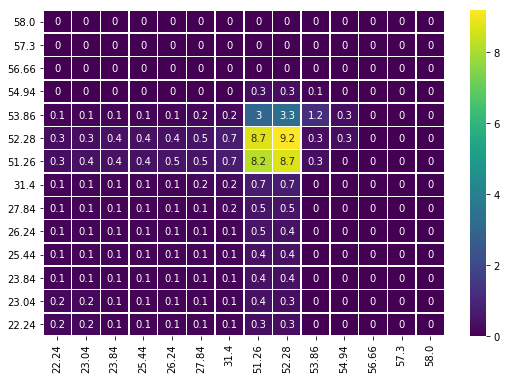

In [11]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Syb, annot=True, linewidths=.5, ax=ax, fmt = 'g',
                   cmap='viridis')

3.75 s, iteration 1, degrees of freedom: 3.48 of 120. convergence criteria fullfilled  0.005
5.52 s, iteration 2, degrees of freedom: 3.48 of 120.  Done.  0.000
RMS [2.73954015074023, 0.09473264297574109]
Warning. Singular Matrix with rank 9 instead of 14
Warning. Singular Matrix with rank 13 instead of 120
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


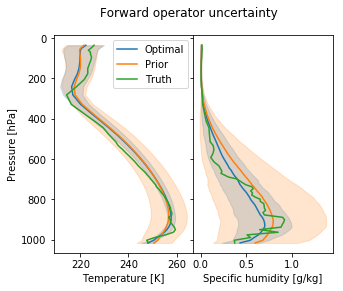

In [12]:
oe_b = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='DJF').to_pandas(),
    x_cov.sel(season='DJF').to_pandas(),
    y_vars,
    y_obs,
    y_cov+Syb,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
    b_vars=b_vars,
    b_p=b_param,
    S_b=b_cov,
)
oe_b.doRetrieval()
supporting_routines.plotMwrResults(oe_b, h=pressure/100, hlabel ='Pressure [hPa]', title='Forward operator uncertainty')


print('RMS', [np.sqrt(np.mean((a-b)**2)) for a,b in zip(supporting_routines.splitTQ(oe_b.x_op), supporting_routines.splitTQ(oe_b.x_truth))])
print(oe_b.chiSquareTest()[0])


# Plot degrees of freedom. 

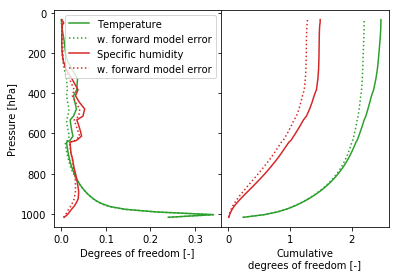

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)


T, Q = [(x) for x in supporting_routines.splitTQ(oe_ref.dgf_x)]
T_e,Q_e = [(x) for x in supporting_routines.splitTQ(oe_b.dgf_x)]


ax1.plot(T, pressure/100, color='C2', label= 'Temperature')
ax1.plot(T_e, pressure/100, color='C2', ls=':', label= 'w. forward model error')


ax1.plot(Q, pressure/100, color='C3', label= 'Specific humidity')
ax1.plot(Q_e, pressure/100, color='C3', ls=':', label= 'w. forward model error')


T, Q = [np.cumsum(x) for x in supporting_routines.splitTQ(oe_ref.dgf_x)]
T_e,Q_e = [np.cumsum(x) for x in supporting_routines.splitTQ(oe_b.dgf_x)]

ax2.plot(T, pressure/100, color='C2', label= 'Temperature')
ax2.plot(T_e, pressure/100, color='C2', ls=':', label= 'w. forward model error')



ax2.plot(Q, pressure/100, color='C3', label= 'Specific humidity')
ax2.plot(Q_e, pressure/100, color='C3', ls=':', label= 'w. forward model error')



ax1.legend()
ax2.set_xlabel('Cumulative\ndegrees of freedom [-]')
ax1.set_xlabel('Degrees of freedom [-]')

ax1.set_ylabel('Pressure [hPa]')
ax1.invert_yaxis()    

fig.subplots_adjust(wspace=0)